This is a C96 Held-Suarez simulation with moisture to demonstrate stability and large-scale characteristics in a climate-like model run. This test is useful to diagnose the effect of dynamics settings on the behavior of the simulated climate, especially how mid-latitude variability is simulated. Note that since Held-Suarez has sinks of heat and potential vorticity it is much more useful for testing dynamical core design than the Baroclinic wave test, which lacks any diabatic physical processes.

We also investigate the 

In [2]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import dask #Chunking will be necessary for the larger datasets
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import ticker, cm, colors
import os
import pandas as pd
import dask
from glob import glob


In [3]:
large = 24; med = 20; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

# H-S Equilibrium States

In [4]:
isigl=np.linspace(0.01,1,32)
ilat=np.linspace(-90,90,90)*np.pi/180.
lat,sigl= np.meshgrid(ilat,isigl)

sigb=0.7
p0=1.e5
kappa=2./7.
ap0k=1./np.power(p0,kappa)
algpk=np.log(ap0k)

Classic Held-Suarez Form:

$$T_{eq} = p^\kappa \left [ T_0 - 60\sin^2\phi - \frac{10}{p_0^\kappa} \cos^2\phi  \log\sigma  \right ] $$

In [5]:
#Classic H-S form
tey=ap0k*(315.0 - 60.0*np.power(np.sin(lat),2))
tez=10.0*(ap0k/kappa)*np.power(np.cos(lat),2)
teq_hs=np.power(sigl*p0,kappa)*(tey - tez*(kappa*np.log(sigl*p0)+algpk))

<ipython-input-6-ef47e1e501d8>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat,sigl,teq_hs,vmax=315,vmin=200)


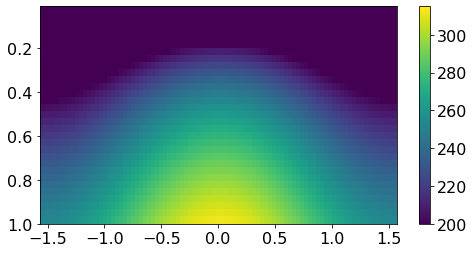

In [6]:
plt.pcolormesh(lat,sigl,teq_hs,vmax=315,vmin=200)
plt.gca().invert_yaxis()
plt.colorbar()

Zurita-Gotor et al. (2022) Form:

$$T_{eq} = \sigma^\kappa T_0 \left [ 1.0 - 0.19\left (1-e^{-\left(\phi/\phi_0\right)^2} \right ) + \frac{0.1}{\kappa}(1-\sigma^\kappa) \right ]$$

$\phi_0$ is a free parameter ``rd_zur`` which controls the latitude of peak baroclinicity; I find $\phi_0 = 40$ most closely reproduces the Held-Suarez $T_{eq}$.

In [113]:
#Z-G 22 Form
rd_zur=40.*np.pi/180. #Parameter: 40 gets closes to traditional H-S
tey= 1.0 - 0.19*(1-np.exp(-np.power(lat/rd_zur,2)))
tmp=np.power(sigl,kappa)
tez=0.1*(1.-tmp)/kappa
teq_z=tmp*315.0*(tey+tez)

<ipython-input-114-aff19b6f6186>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lat,sigl,teq_z,vmax=315,vmin=200)


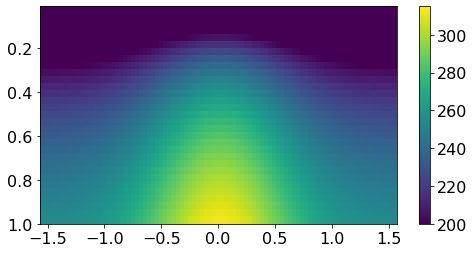

In [114]:
plt.pcolormesh(lat,sigl,teq_z,vmax=315,vmin=200)
plt.gca().invert_yaxis()
plt.colorbar()

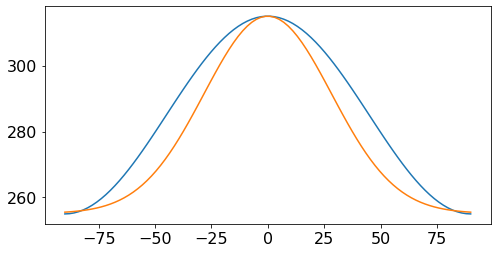

In [115]:
plt.plot(ilat*180./np.pi,teq_hs[-1,:])
plt.plot(ilat*180./np.pi,teq_z[-1,:])

The temperature is relaxed back to $T_{eq}$ **implicit-in-time** using the spatially-dependent timescales defined in HS94.

$$\frac{T^{n+1} - T^n}{\Delta t} = -k \left(T^{n+1} - T_{eq} \right)$$

$$\Rightarrow \frac{\partial T}{\partial t} = \frac{1}{\Delta t} \frac{k}{1+k} \left ( T_{eq} - T^n\right )$$

where 

$$k = k_a + \left(k_s - k_a\right) \max\left(0,\frac{ \sigma - \sigma_b}{1 - \sigma_b}\right) \cos^4\phi $$

for $k_a = \Delta t/ 40~\mathrm{d}$, $k_s = \Delta t/4~\mathrm{d}$, and $\sigma_b = 0.7$.

Text(0.5, 1.0, 'Relaxation timescale in days')

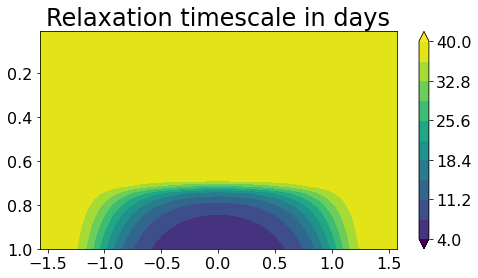

In [132]:
ka=1./40.
ks=1./4.
sigb=0.7
ds=(sigl-sigb)/(1.-sigb)
ds[np.where(ds<0)] = 0
k=ka + (ks-ka)*ds*np.power(np.cos(lat),4)
plt.contourf(lat,sigl,1./k,vmin=0,levels=np.linspace(4,40,11),extend='both')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Relaxation timescale in days")

# H-S Results

In [111]:
infileHS="/archive/lmh/SHiELD/202108/C96.L63.solo.HS/history/0000000000/atmos_30day_ave.nc"
daHS=xa.open_dataset(infileHS,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR

In [12]:
daHS_mean=daHS.sel(time=slice(300,)).mean(dim=("lon","time"))

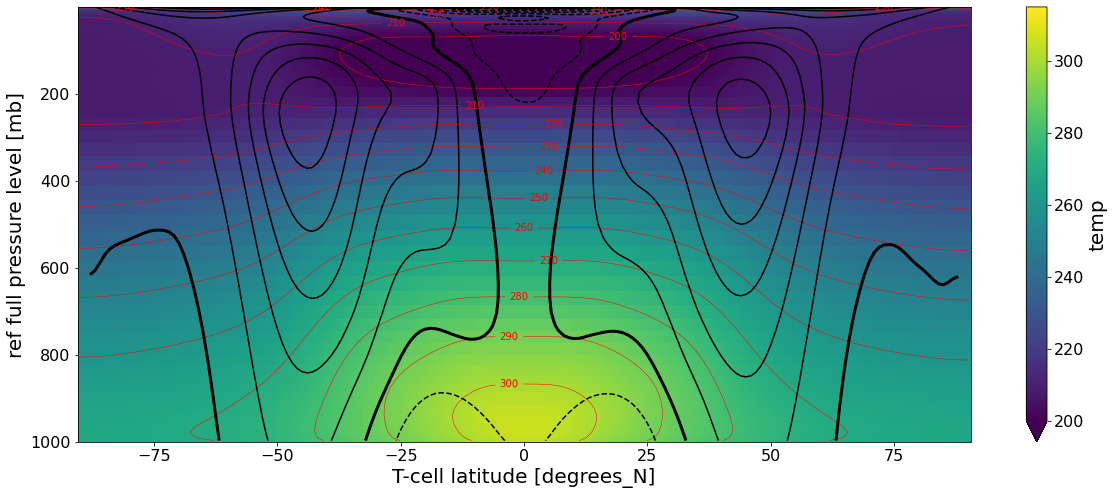

In [37]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(20,8),sharey=True)
daHS_mean.temp.plot(yincrease=False,ax=ax,vmin=200,vmax=315)
cn=daHS_mean.temp.plot.contour(ax=ax,levels=np.arange(200,321,10),colors='red',linewidths=0.5)
plt.clabel(cn,fmt='%3d')
daHS_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(5,51,5),colors='k')
daHS_mean.sel(lat=slice(-88,88)).ucomp.plot.contour(yincrease=False,ax=ax,levels=(0,),colors='k',linewidths=3)
daHS_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(-50,0,5),linestyles='--',colors='k');

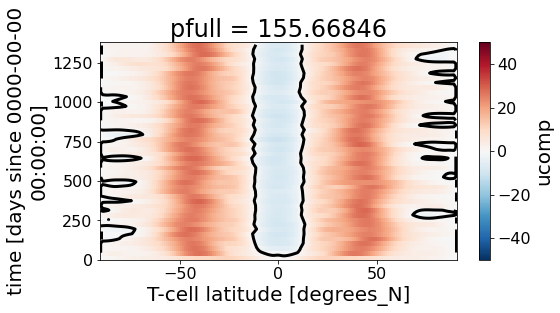

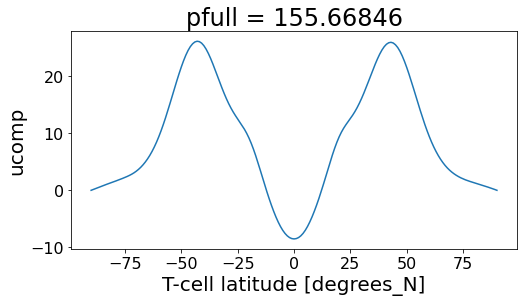

In [92]:
daHS_ts=daHS.sel(pfull=150,method="nearest").mean(dim="lon")
daHS_ts.ucomp.plot(vmin=-50,vmax=50,cmap=cm.get_cmap("RdBu_r"))

daHS_ts.ucomp.plot.contour(levels=(0,),colors='k',linewidths=3)

plt.figure()
daHS_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot()

Here's a cool trick: FV3 can write out products as a standard diagnostic. This makes it **easy** to compute time-mean eddy fluxes *without* needing to write out data every six hours or whatever:
$$ \overline{u'v'} = \overline{\left(u - \overline{u}\right) \left(v - \overline{v}\right)} = \overline{uv} - \left(\overline{u}\right) \left(\overline{v}\right)$$.

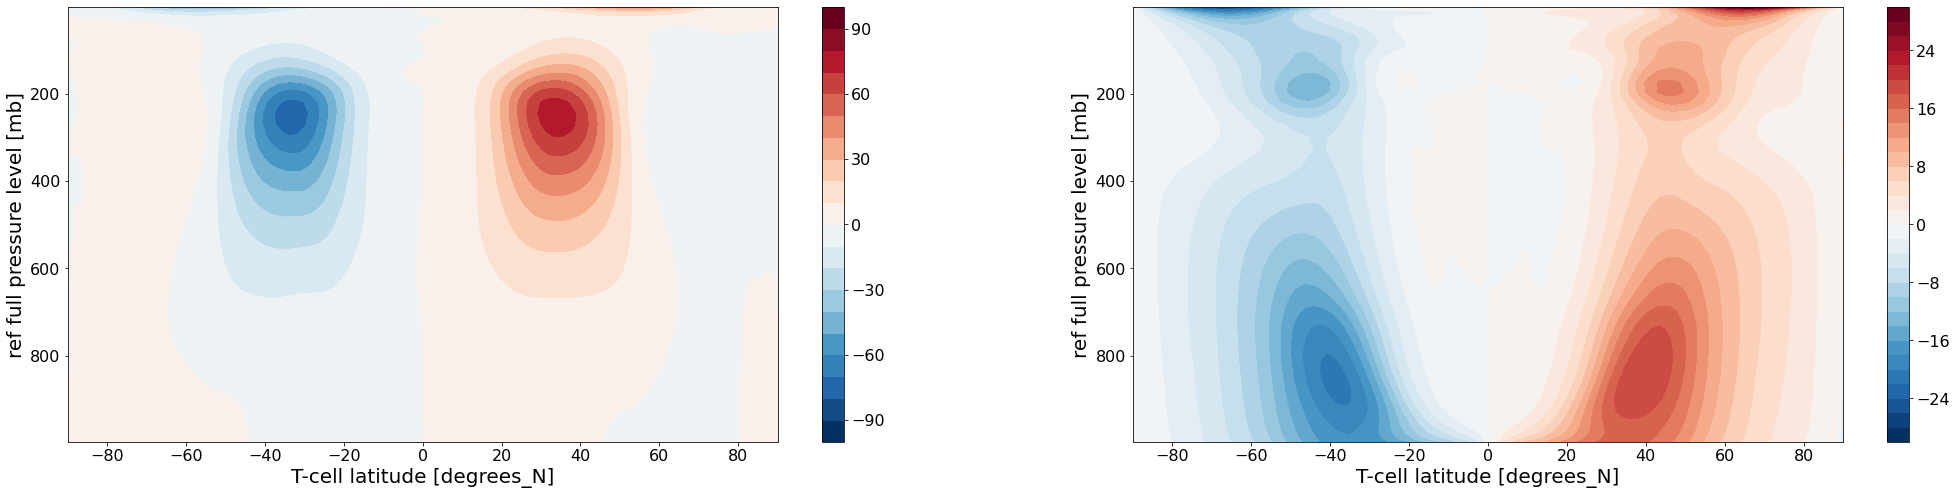

In [52]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(35,8))

uveddy=daHS_mean.uv - daHS_mean.ucomp*daHS_mean.vcomp
uveddy.plot.contourf(yincrease=False,ax=ax[0],levels=np.arange(-100,101,10))

Tveddy=daHS_mean.vt - daHS_mean.temp*daHS_mean.vcomp
Tveddy.plot.contourf(yincrease=False,ax=ax[1],levels=np.arange(-30,31,2))

# Zurita-Gotor et al. 2022 tests

This form starts with the parameter $\phi_0=40$ which comes closest to the traditional Held-Suarez setup

In [64]:
infileHSz40="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita40/history/0000000000/atmos_30day_ave.nc"
daHSz40=xa.open_dataset(infileHSz40,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz40_mean=daHSz40.sel(time=slice(300,1400)).mean(dim=("lon","time"))

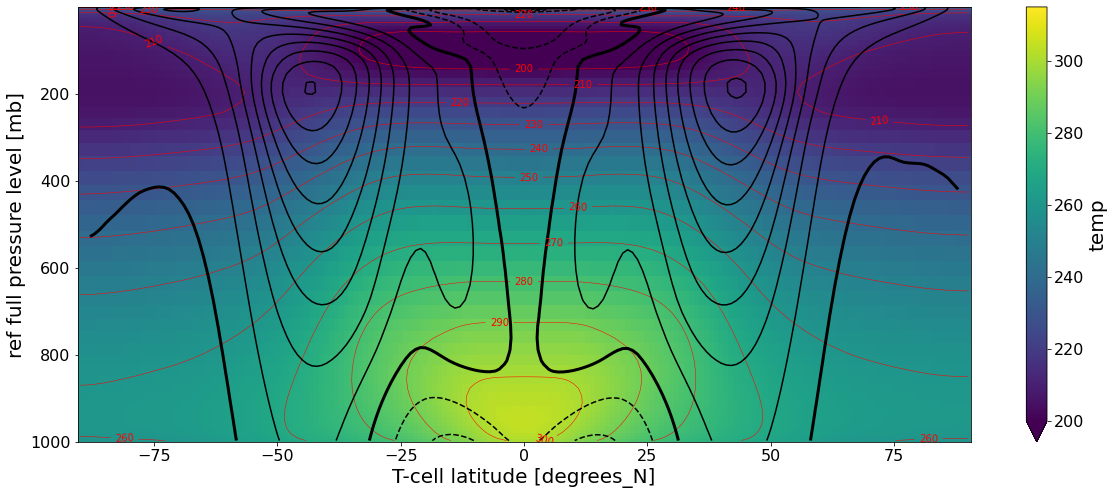

In [65]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(20,8),sharey=True)
daHSz40_mean.temp.plot(yincrease=False,ax=ax,vmin=200,vmax=315)
cn=daHSz40_mean.temp.plot.contour(ax=ax,levels=np.arange(200,321,10),colors='red',linewidths=0.5)
plt.clabel(cn,fmt='%3d')
daHSz40_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(5,51,5),colors='k')
daHSz40_mean.sel(lat=slice(-88,88)).ucomp.plot.contour(yincrease=False,ax=ax,levels=(0,),colors='k',linewidths=3)
daHSz40_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(-50,0,5),linestyles='--',colors='k');

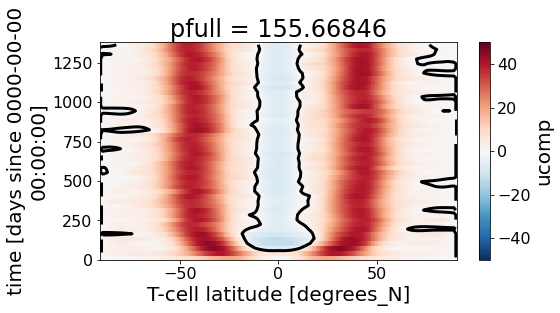

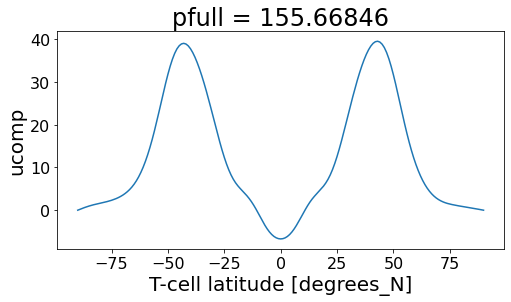

In [89]:
daHSz40_ts=daHSz40.sel(pfull=150,method="nearest").mean(dim="lon")
daHSz40_ts.ucomp.plot(vmin=-50,vmax=50,cmap=cm.get_cmap("RdBu_r"))

daHSz40_ts.ucomp.plot.contour(levels=(0,),colors='k',linewidths=3)

plt.figure()
daHSz40_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot()

# $\phi_0 = 20$

In [62]:
#This one has tropospheric superrotation for a while (at, say, t=300 d) before losing it.

infileHSz20="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita20/history/0000000000/atmos_30day_ave.nc"
daHSz20=xa.open_dataset(infileHSz20,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz20_mean=daHSz20.sel(time=slice(300,1400)).mean(dim=("lon","time"))

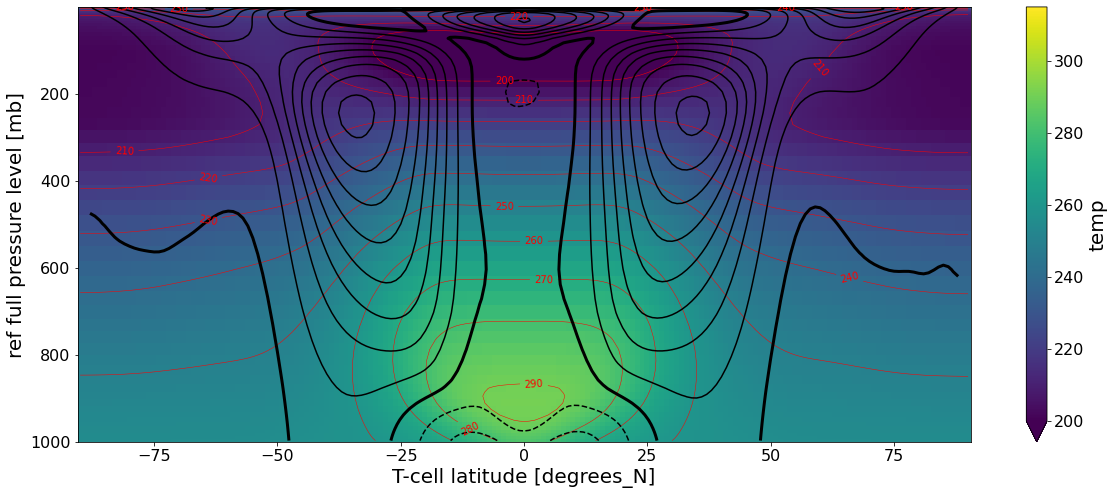

In [63]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(20,8),sharey=True)
daHSz20_mean.temp.plot(yincrease=False,ax=ax,vmin=200,vmax=315)
cn=daHSz20_mean.temp.plot.contour(ax=ax,levels=np.arange(200,321,10),colors='red',linewidths=0.5)
plt.clabel(cn,fmt='%3d')
daHSz20_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(5,51,5),colors='k')
daHSz20_mean.sel(lat=slice(-88,88)).ucomp.plot.contour(yincrease=False,ax=ax,levels=(0,),colors='k',linewidths=3)
daHSz20_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(-50,0,5),linestyles='--',colors='k');

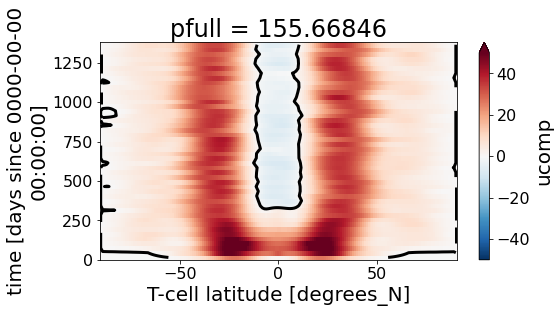

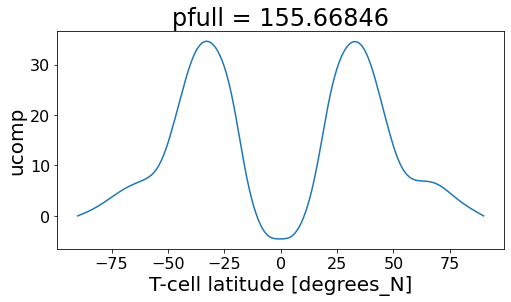

In [88]:
daHSz20_ts=daHSz20.sel(pfull=150,method="nearest").mean(dim="lon")
daHSz20_ts.ucomp.plot(vmin=-50,vmax=50,cmap=cm.get_cmap("RdBu_r"))

daHSz20_ts.ucomp.plot.contour(levels=(0,),colors='k',linewidths=3)

plt.figure()
daHSz20_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot()

# $\phi_0 = 20$

In [66]:
infileHSz10="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita10/history/0000000000/atmos_30day_ave.nc"
daHSz10=xa.open_dataset(infileHSz10,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz10_mean=daHSz10.sel(time=slice(300,1400)).mean(dim=("lon","time"))

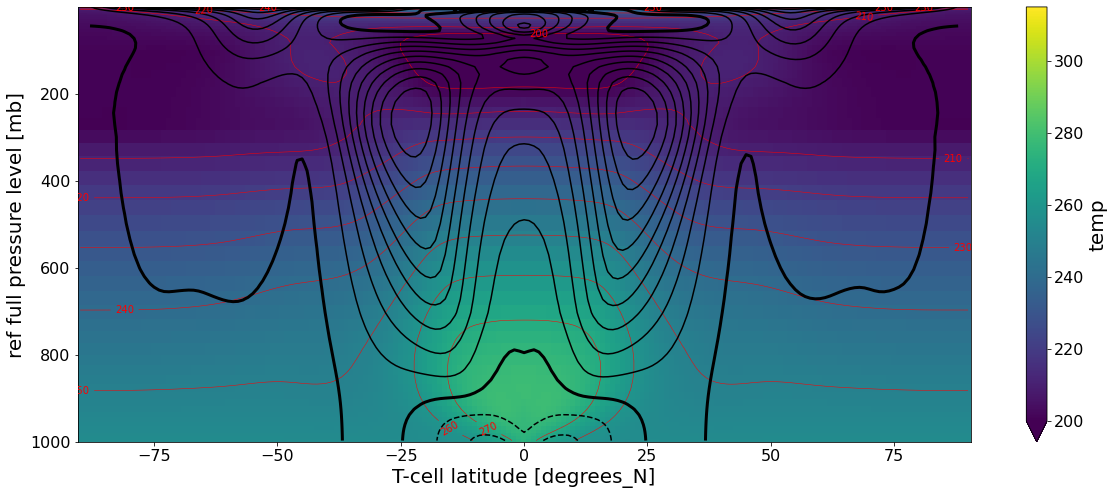

In [67]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(20,8),sharey=True)
daHSz10_mean.temp.plot(yincrease=False,ax=ax,vmin=200,vmax=315)
cn=daHSz10_mean.temp.plot.contour(ax=ax,levels=np.arange(200,321,10),colors='red',linewidths=0.5)
plt.clabel(cn,fmt='%3d')
daHSz10_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(5,51,5),colors='k')
daHSz10_mean.sel(lat=slice(-88,88)).ucomp.plot.contour(yincrease=False,ax=ax,levels=(0,),colors='k',linewidths=3)
daHSz10_mean.ucomp.plot.contour(yincrease=False,ax=ax,levels=np.arange(-50,0,5),linestyles='--',colors='k');

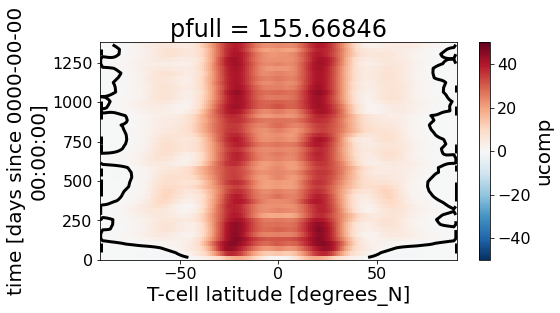

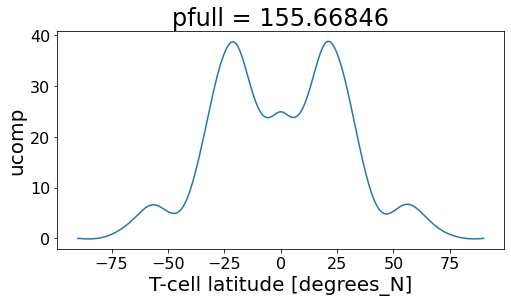

In [98]:
daHSz10_ts=daHSz10.sel(pfull=150,method="nearest").mean(dim="lon")
daHSz10_ts.ucomp.plot(vmin=-50,vmax=50,cmap=cm.get_cmap("RdBu_r"))

daHSz10_ts.ucomp.plot.contour(levels=(0,),colors='k',linewidths=3)

plt.figure()
daHSz10_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot()

# Overview: equilbrium zonal-mean winds at 150 mb

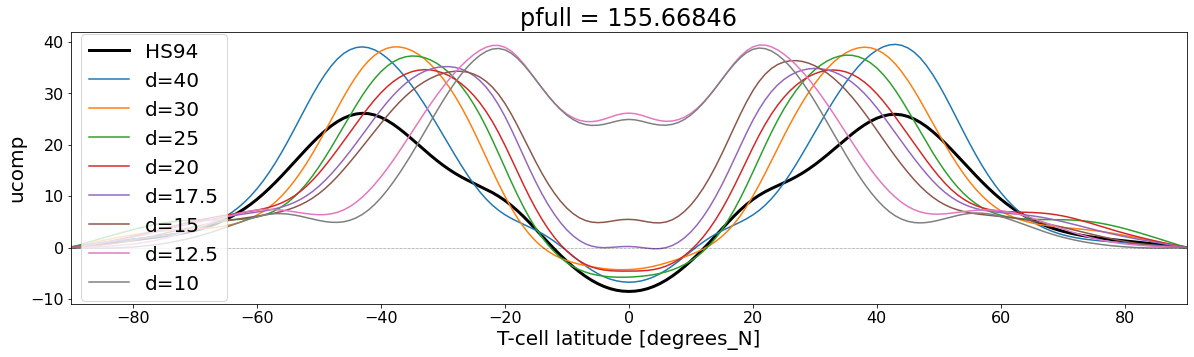

In [110]:
infileHSz30="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita30/history/0000000000/atmos_30day_ave.nc"
daHSz30=xa.open_dataset(infileHSz30,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz30_ts=daHSz30.sel(pfull=150,method="nearest").mean(dim="lon")


infileHSz25="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita/history/0000000000/atmos_30day_ave.nc"
daHSz25=xa.open_dataset(infileHSz25,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz25_ts=daHSz25.sel(pfull=150,method="nearest").mean(dim="lon")


infileHSz17_5="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita17.5/history/0000000000/atmos_30day_ave.nc"
daHSz17_5=xa.open_dataset(infileHSz17_5,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz17_5_ts=daHSz17_5.sel(pfull=150,method="nearest").mean(dim="lon")

infileHSz15="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita15/history/0000000000/atmos_30day_ave.nc"
daHSz15=xa.open_dataset(infileHSz15,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz15_ts=daHSz15.sel(pfull=150,method="nearest").mean(dim="lon")

infileHSz12_5="/archive/lmh/SHiELD/202108/C96.L63.solo.HSzurita12.5/history/0000000000/atmos_30day_ave.nc"
daHSz12_5=xa.open_dataset(infileHSz12_5,decode_times=False,chunks={'time': 1}) #xarray is confused by solo_core's NO_CALENDAR
daHSz12_5_ts=daHSz12_5.sel(pfull=150,method="nearest").mean(dim="lon")

plt.figure(figsize=(20,5))
daHS_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='HS94',linewidth='3',color='k')
daHSz40_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=40')
daHSz30_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=30')
daHSz25_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=25')
daHSz20_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=20')
daHSz17_5_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=17.5')
daHSz15_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=15')
daHSz12_5_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=12.5')
daHSz10_ts.ucomp.sel(time=slice(300,1400)).mean(dim="time").plot(label='d=10')
plt.gca().plot((-90,90),(0,0),linewidth='0.5',color='k',linestyle=':')
plt.gca().set_xlim((-90,90))
plt.legend(loc="center left")